In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from Bio import SeqUtils
from autoamp.finetune import Sequence
from autoamp.evolve import Esm2ProteinLangaugeModel

In [2]:
# Load the data
df = pd.read_csv("/homes/psetty/projects/master_paper/inputs/dbaasp_complete.csv")

# Remove multimer sequences
df = df[df["COMPLEXITY"] == "Monomer"]

# Remove any rows with nan
df = df.dropna(
    subset=[
        "SEQUENCE", # Stores the actual peptide sequence as a string
        "TARGET GROUP", # Stores the type of bacteria it's effective against (e.g., Gram negative)
        "TARGET ACTIVITY - UNIT", # The units the activity is measure in (ug/ml, uM, nmol/g, µg/g)
        "TARGET ACTIVITY - CONCENTRATION", # The concentration values the experiment was conducted at
        "TARGET ACTIVITY - ACTIVITY MEASURE GROUP", # Whether the activity measure was MIC or IC50
        "TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)" # The measured target activity
    ]
)

# Remove d-aminoacids
df = df[~df['SEQUENCE'].str.contains('[a-z]')]

# Remove unknown amino acids
df = df[~df['SEQUENCE'].str.contains('X')]

# Make sure none of the sequences have empty strings
df["SEQUENCE"] = [x.replace(" ", "") for x in df["SEQUENCE"]]

# Remove any target activities measured in µg/g 
# There were only a few and they were all 0.0 except for one which was 50.
df = df[df["TARGET ACTIVITY - UNIT"] != "µg/g"]

def convert_activity_units_to_ug_per_ml(row):
    """Convert activity units to ug/ml."""
    # Extract the necessary entries from the dataframe row
    sequence = row["SEQUENCE"]
    unit = row["TARGET ACTIVITY - UNIT"]
    activity = row["TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)"]

    # If the units are already correct, return early
    if unit == "µg/ml":
        return activity

    # Compute the molecular weight in daltons
    molecular_weight_da = SeqUtils.molecular_weight(sequence, seq_type="protein")

    # This conversion formula is the same whether activity
    # is measure in nmol/g or µM
    return activity * (molecular_weight_da / 1000)
    
# Apply the unit conversion to normalize activity units to ug/ml
df["normalized_activity"] = df.apply(convert_activity_units_to_ug_per_ml, axis=1)

# Only consider MIC activity scores, not IC50
df = df[df["TARGET ACTIVITY - ACTIVITY MEASURE GROUP"] == "MIC"]

# Select the minimum MIC across the different concentration ranges for each sequence
df['min_mic_activity'] = df.groupby('SEQUENCE')['normalized_activity'].transform('min')

# Remove any sequences that are not confirmed to be effective against Gram negative bacteria
df = df[df['TARGET GROUP'].str.contains('Gram-')]

# Now that the min MIC scores are computed, drop the duplicate sequences
df = df.drop_duplicates(subset='SEQUENCE')

# target_group = get_target_group(df)
# TODO: Consider filtering out any ug/ml past a threshold (e.g., 1000)

/tmp/ipykernel_2601036/3360923481.py:2: DtypeWarning: Columns (16,17,23,24,31,32,38,53,54,57,63,64,65,66,67,68,71,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/homes/psetty/projects/master_paper/inputs/dbaasp_complete.csv")


In [87]:
df['min_mic_activity'].describe()

count     9602.000000
mean       116.400804
std        567.774285
min          0.000250
25%          4.100000
50%         13.475183
75%         62.000000
max      19548.641988
Name: min_mic_activity, dtype: float64

<Axes: >

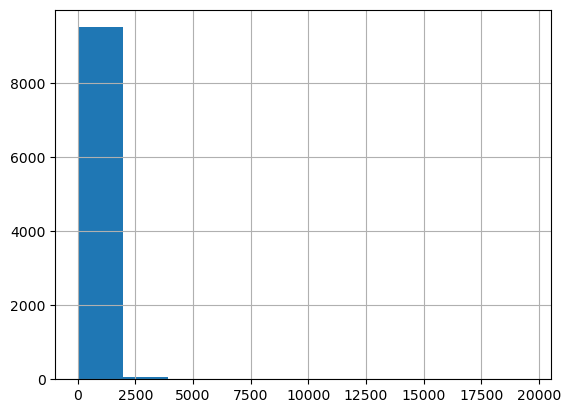

In [88]:
df['min_mic_activity'].hist()

In [80]:
def get_target_group(df: pd.DataFrame) -> np.ndarray:
    target_group = df["TARGET GROUP"].values
    print(target_group)
    gram = []
    for x in target_group:
        try:
            if 'Gram+' in x and 'Gram-' in x:
                gram.append('both')
            elif 'Gram+' in x:
                gram.append('Gram+')
            elif 'Gram-' in x:
                gram.append('Gram-')
            else:
                gram.append('other')
        except:
            gram.append('other') # Handle nans

    return np.array(gram)

target_group = get_target_group(df)

['Gram+' 'Gram+,Gram-,Cancer,Mammalian Cell' 'Gram+,Gram-' ...
 'Gram+,Gram-,Mammalian Cell' 'Gram+,Gram-,Mammalian Cell'
 'Gram+,Gram-,Mammalian Cell']


In [81]:
Counter(target_group), len(target_group)

(Counter({'Gram+': 534, 'both': 8533, 'other': 243, 'Gram-': 1060}), 10370)

In [9]:
# Note: Active peptides are defined MIC<25 µg/ml, and Non-Active as having MIC>100 µg/ml
# Source: https://dbaasp.org/help

In [59]:
from autoamp.filters import LengthFilter
from autoamp.filters import DAminoAcidsFilter
from autoamp.filters import UnknownAminoAcidsFilter
from autoamp.filters import ChargeFilter
from autoamp.filters import HydrophobicFilter
from autoamp.filters import PHAdjustmentFilter
from autoamp.filters import NTerminalFilter
from autoamp.filters import DisallowedPairsFilter
from autoamp.filters import BetaSheetFilter
from autoamp.filters import FilterChain

# # Setup the filters
# filters = [
#     LengthFilter(threshold=49),
#     DAminoAcidsFilter(),
#     UnknownAminoAcidsFilter(),
#     #ChargeFilter(threshold=0.25),
#     #HydrophobicFilter(threshold=0.25),
#     PHAdjustmentFilter(threshold=0.75),
#     NTerminalFilter(),
#     DisallowedPairsFilter(),
#     #BetaSheetFilter(),
# ]

# # Chain the filters
# chain = FilterChain(filters=filters, verbose=True)

# # Filter the sequences
# filtered_seqs = chain.apply(sequences)

# # Reset variables
# sequences = filtered_seqs
# activity = np.array([float(s.tag) for s in filtered_seqs])

In [85]:
sequences[0]

Sequence(sequence='LFIFFF', tag='15.0')

In [180]:
import torch 
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [3]:
activity = df["min_mic_activity"].values
#activity = df["TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)"].values
sequences = [Sequence(sequence=seq, tag=str(a)) for seq, a in zip(df["SEQUENCE"], activity)]

In [4]:
# Base models
model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t33_650M_UR50D',#'../runs/esm2-8m-finetune-v1/',
    batch_size=8,
)

model_outputs = model.infer(sequences)

embeddings = np.array([output.sequence_embeddings for output in model_outputs])
embeddings.shape

/homes/abrace/.conda/envs/sdl-amp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  3%|█████▌                                                                                                                                                         | 42/1201 [00:02<01:05, 17.69it/s]


KeyboardInterrupt: 

In [26]:
# TODO: Plot a curve with MIC ground truth on y-axis and predicted MIC on x-axis
# TODO: Make an ensemble regression predictor (make the above plot for each LLM)
# TODO: For the mutated sequences, use the ensemble regression to predict the ones with better MIC

In [118]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne(
    X: np.ndarray,
    y: np.ndarray,
    color_label: str,
    title: str = '',
) -> None:
    # Create a t-SNE model and fit it to the data
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X)
    
    # Create a DataFrame for the t-SNE results
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['label'] = y
    
    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        x=df_tsne['Component 1'], y=df_tsne['Component 2'], 
        c=df_tsne['label'], cmap='viridis', alpha=0.7
    )
    
    # Enhance plot aesthetics
    plt.colorbar(scatter, label=color_label)
    plt.title(title)
    plt.xlabel(r'$z_1$')
    plt.ylabel(r'$z_2$')
    plt.grid(True)
    plt.show()


def plot_tsne_categorical(X_tsne: np.ndarray, labels: np.ndarray, color_label: str, title: str = '') -> None:
    # Create a t-SNE model and fit it to the data
    # tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    # X_tsne = tsne.fit_transform(X)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    
    # Define a color map
    colors = {'both': 'red', 'Gram+': 'magenta', 'Gram-': 'green', 'other': 'blue'}

    print(np.unique(labels))
    
    # Plot each category with a different color
    for category in np.unique(labels):
        idx = labels == category
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[category], label=category, alpha=0.6)
    
    # Enhance plot aesthetics
    plt.legend()
    #plt.colorbar(scatter, label=color_label)
    plt.title(title)
    plt.xlabel(r'$z_1$')
    plt.ylabel(r'$z_2$')
    plt.grid(True)
    plt.show()


In [119]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(embeddings)

['Gram+' 'Gram-' 'both' 'other']


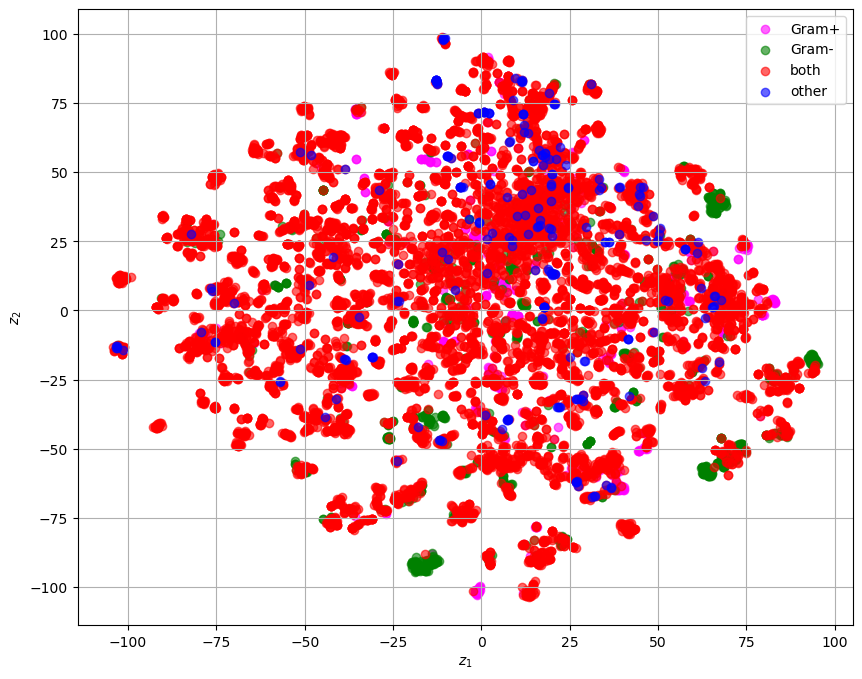

In [91]:
plot_tsne_categorical(X_tsne, target_group, color_label="Target Group")

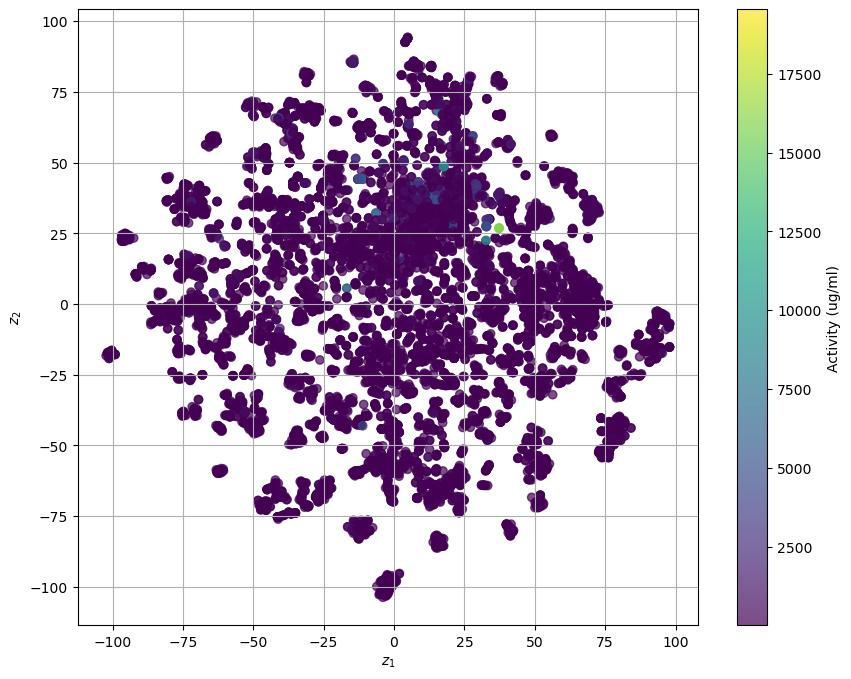

In [120]:
plot_tsne(embeddings, activity, color_label="Activity (ug/ml)")

Num examples: 500


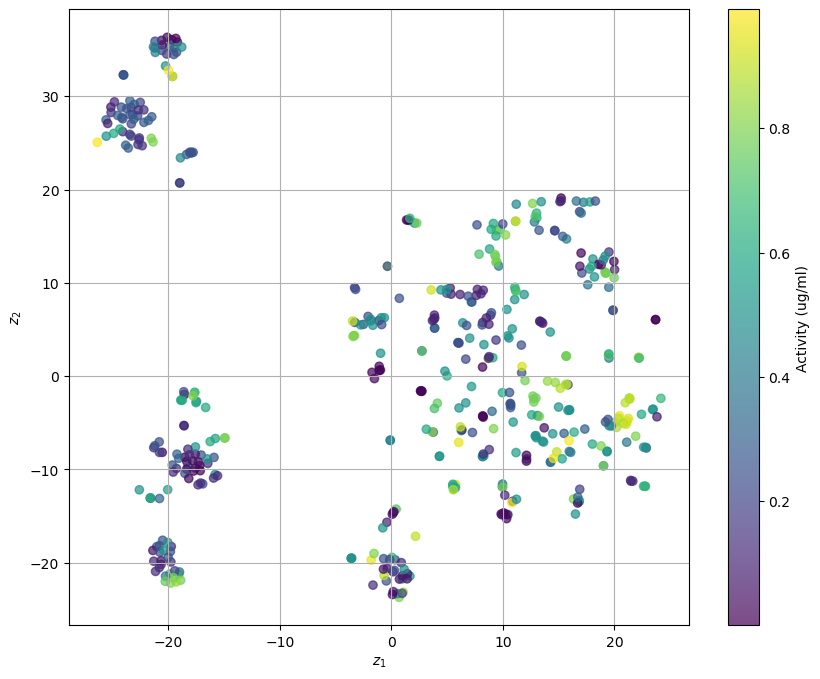

In [121]:
mask = activity < 1
print(f"Num examples: {np.sum(mask)}")
plot_tsne(embeddings[mask], activity[mask], color_label="Activity (ug/ml)")

In [122]:
embeddings[activity < 1].shape

(500, 320)

In [116]:
bins = np.linspace(int(np.floor(np.min(activity))), 10, int(np.ceil(np.max(activity))))
labels = np.digitize(activity, bins=[0, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

from collections import Counter
Counter(labels)

Counter({11: 13019,
         1: 225,
         9: 63,
         6: 54,
         10: 61,
         4: 88,
         8: 60,
         5: 81,
         3: 15,
         7: 34,
         2: 25})

In [117]:
labels

array([11, 11, 11, ..., 11, 11, 11])

array([[<Axes: title={'center': '0'}>]], dtype=object)

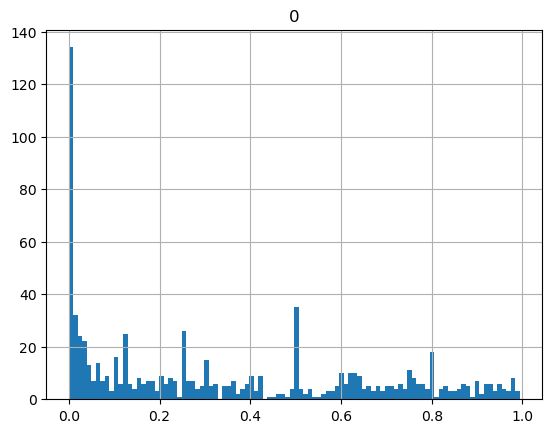

In [137]:
pd.DataFrame(activity[activity < 1]).hist(bins=100)

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Set the random seed
np.random.seed(0)

# Filter the data
activity_threshold = 1000.0
X = embeddings[activity < activity_threshold]
labels = activity[activity < activity_threshold]

print("Data samples:", len(X)) 

# Put the continuous targets into bins
#bins = [0.25]
bins = [25.0]
y = np.digitize(labels, bins=bins)

print("Labels before SMOTE:", Counter(y))

# Determine the number of 20% of the smallest class
smallest_class_size = min(Counter(y).values())
test_set_size = round(0.2 * smallest_class_size)
print(f"Test set consists of {test_set_size} examples from each class")

# Partition the sets of indices into each class
indices = np.arange(len(y))
indices_class0 = indices[y == 0]
indices_class1 = indices[y == 1]

# Randomly shuffle the indices belonging to each class
np.random.shuffle(indices_class0)
np.random.shuffle(indices_class1)

# Split the data into train and test indices
train_indices = np.concatenate((indices_class0[test_set_size:], indices_class1[test_set_size:]))
test_indices = np.concatenate((indices_class0[:test_set_size], indices_class1[:test_set_size]))

# Reshufle the train and test indices so that they are not simply concatenated between the two classes
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Get the training and testing splits
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Splitting the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

# Oversample using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Labels after SMOTE:", Counter(y_resampled))

# Creating the pipeline with MinMaxScaler and MLPRegressor
pipeline = Pipeline([
    ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, early_stopping=True, random_state=0))
])

# pipeline = Pipeline([
#     ('mlp', RandomForestClassifier(max_depth=10, random_state=0))
# ])
# pipeline = Pipeline([
#     ('mlp', LogisticRegression(random_state=0))
# ])

# Training the model
#pipeline.fit(X_train, y_train)
# Training the model
pipeline.fit(X_resampled, y_resampled)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# LogisticRegression with finetune 8M
# Test Accuracy: 0.8088235294117647
# Train Accuracy: 0.9432973146464106

# LogisticRegression with finetune 35M
# Test Accuracy: 0.7794117647058824
# Train Accuracy: 0.9544238793195677

# LogisticRegression with base 8M
# Test Accuracy: 0.7058823529411765
# Train Accuracy: 0.8963303733818337

# LogisticRegression with base 35M
# Test Accuracy: 0.75
# Train Accuracy: 0.9079918690488927

# LogisticRegression with base 650M
# Test Accuracy: 0.7794117647058824
# Train Accuracy: 0.9359152669305659

Data samples: 9415
Labels before SMOTE: Counter({0: 5890, 1: 3525})
Test set consists of 705 examples from each class
Train set size: 8005
Test set size: 1410
Labels after SMOTE: Counter({1: 5185, 0: 5185})
Test Accuracy: 0.7475177304964539
Train Accuracy: 0.9572767020612117
Confusion Matrix:
[[570 135]
 [221 484]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       705
           1       0.78      0.69      0.73       705

    accuracy                           0.75      1410
   macro avg       0.75      0.75      0.75      1410
weighted avg       0.75      0.75      0.75      1410



In [ ]:
# ESM 8M results
# Test Accuracy: 0.795
# Train Accuracy: 0.987

# ESM 650M results
# Test Accuracy: 0.782
# Train Accuracy: 0.970

# ESM 8M finetune results
# Test Accuracy: 0.826
# Train Accuracy: 0.990

# ESM 650M finetune results
# Test Accuracy: 0.977 or .77 if activity threshold == 1
# Train Accuracy: 0.995

In [118]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Set the random seed
np.random.seed(0)

# Filter the data
ativity_threshold = 1.0
X = embeddings[activity < ativity_threshold]
y = activity[activity < ativity_threshold]

print("Data samples:", len(X)) 

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the pipeline with MinMaxScaler and MLPRegressor
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=0))
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_r2 = r2_score(y_train, pipeline.predict(X_train))

print(f"Test Mean Squared Error: {mse}")
print(f"Test R^2 Score: {r2}")
print(f"Train R^2 Score: {train_r2}")

Data samples: 802
Test Mean Squared Error: 0.061972496639148944
Test R^2 Score: 0.3914006654106519
Train R^2 Score: 0.4635913927923996


<Axes: >

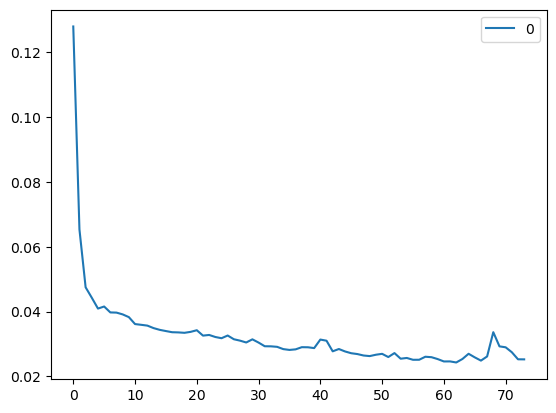

In [91]:
pd.DataFrame(pipeline["mlp"].loss_curve_).plot()

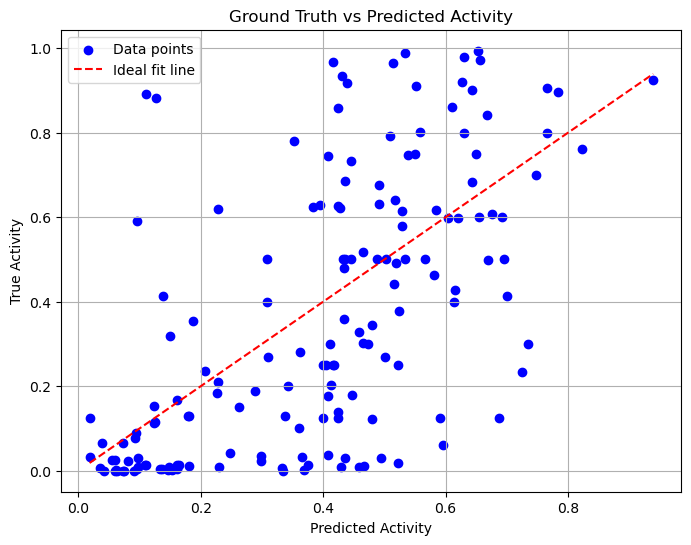

In [93]:
# Plotting the ground truth vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', label='Data points')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', linestyle='--', label='Ideal fit line')
plt.xlabel('Predicted Activity')
plt.ylabel('True Activity')
plt.title('Ground Truth vs Predicted Activity')
plt.legend()
plt.grid(True)
plt.show()